In [1]:
using Pkg
Pkg.activate(".")

 Activating environment at `~/GitHub/MathSys/teaching/MA999/MA999-slides/Project.toml`


In [2]:
using Revise
using Agents
using Plots
using LightGraphs
using GraphPlot, Compose
using Statistics
using DataFrames

# MA999 - Agent based modelling

## MathSys CDT 2021

### Lecturer: Colm Connaughton

## Summary

* What is agent-based modelling?
* Example 1: one-dimensional cellular automata
* Agents.jl - Agent-based modelling in Julia
* Example 2: Traffic flow and congestion games
* Mathematical analysis of congestion games: Braess' paradox and the price of anarchy
* Example 3: Gaia hypothesis: planetary homeostasis in the Daisyworld model
* Mathematical analysis of the mean field Daisyworld model

## What is agent based modelling?
* An ABM is a model built from multiple autonomous agents that react to their environment (including the other agents) using a predefined set of rules.
* The environment can, in turn, be altered by the actions of the agents.
### Advantages
* Massive flexibility - many of the assumptions of "mathematical" models can be relaxed.
* Easy to simulate and visualise.
* Can handle heterogeneity in a natural way - not all agents need to be identical.
* Often the only option for studying complex adaptive systems.

### Disadvantages
* Potentially large number of parameters and rather under-developed theory for model selection.
* Temptation to favour model "fidelity" over parsimony can lead to inappropriate predictive use.
* Can become computationally expensive.
* Complex ABMs are difficult to understand.

##  Example 1: one-dimensional cellular automata

* "Agents" are nodes on a one-dimensional grid: $G = \{v1, v2, \ldots v_N\}$.
* Each agent has a single "state" attribute,$x_i$, taking values 0 or 1.
* Time proceeds in discrete steps.
* At each step, agents update states based on neighbouring states.
* Such a model is specified by:
    * initial state, $X(0) = \{x_1(0), x_2(0), \ldots x_N(0)\}$.
    * an update rule that maps the current states of an agent and its neighbours to the new state:
    $$S : (x_{i-1},\, x_i,\, x_{i+1}) \to x_i$$
    

##  Example 1: one-dimensional cellular automata

$$S : (x_{i-1},\, x_i,\, x_{i+1}) \to x_i$$

* How many such rules are there?
    * a rule must specify an output bit for $2^3 = 8$ possible input configurations of 3 bits.
    * hence there are $2^8 = 256$ rules. 

## Naming one-dimensional CA : the Wolfram code

Stephen Wolfram devised what is now the standard rule for naming 1D CA. Each rule is assigned a number between 0 and 255.

* Write each of the possible configurations in order and its corresponding output value as follows:

|Input | 111 | 110 | 101 | 100 | 011 | 010 | 001| 000 |
| - | - | - | - | - | - | - | - | - |
|Output | 0 | 1 | 1 | 0 | 1 | 1 | 1 | 0 |

* Interpret the output row as a binary integer to give the rule number.

## Naming one-dimensional CA : the Wolfram code

|Input | 111 | 110 | 101 | 100 | 011 | 010 | 001| 000 |
| - | - | - | - | - | - | - | - | - |
|Output | 0 | 1 | 1 | 0 | 1 | 1 | 1 | 0 |

The above rule is $0 \times 128 + 1\times 64 + 1\times 32 + 0\times 16 + 1\times 8 +1\times 4 + 1 \times 2 + 0\times 1 = 110$. 

Let's simulate rule 110 in Julia to see what the evolution looks like.

## Simulation of 1D CA in Julia

The Julia package Agents.jl provides a framework for simulating ABMs. I have written a custom module called ```CA1D``` that uses Agents.jl to simulate 1D CA. Let's first play around with it. Then we will look at how the code works. First load the module:

In [10]:
include("code/CA1D.jl")

Main.CA1D

### Step 1 : define the update rule for an agent

Agents.jl uses dictionaries a lot so learn how they work: 

In [11]:
rule110 = Dict("111"=>0, "110"=>1, "101"=>1, "100"=>0, "011"=>1,
            "010"=>1, "001"=>1, "000"=>0)

rule22 = Dict("111"=>0, "110"=>0, "101"=>0, "100"=>1, "011"=>0,
            "010"=>1, "001"=>1, "000"=>0)

Dict{String,Int64} with 8 entries:
  "000" => 0
  "111" => 0
  "001" => 1
  "011" => 0
  "101" => 0
  "110" => 0
  "010" => 1
  "100" => 1

### Step 2 : build and initialise the model

Building involves several sub-steps:

* Define the spatial grid - in this case just a 1D grid.
* Pass any additional model parameters to the model - none here
* Add the agents to the model - trivial here since the agents and the grid are the same.
* Initialise the parameters of the model - here we set the middle agent to be active

In [12]:
n = 101
model = CA1D.initialise(;rules = rule110, gridsize = n, initial_condition="singleton")

AgentBasedModel with 101 agents of type CA1DAgent
 space: GridSpace with size (101,), metric=euclidean and periodic=true
 scheduler: fastest
 properties: Dict(:rules => Dict("000" => 0,"111" => 0,"001" => 1,"011" => 1,"101" => 1,"110" => 1,"010" => 1,"100" => 0))

### Step 3 : run the model and gather some data

* We just need to specify the number of steps and let Agents.jl take care of the rest.
* We do a number of runs half the size of the grid.
* Data is returned from the simulation in a dataframe object : https://juliadata.github.io/DataFrames.jl/stable/

In [20]:
steps = round(Int64, n)
p, data = CA1D.run(;rules = rule22, gridsize = n, initial_condition="singleton", nsteps=steps, update="synchronous")

(Plot{Plots.GRBackend() n=1}, [0 0 … 0 1; 1 0 … 1 1; … ; 1 1 … 1 0; 0 0 … 0 0])

### Step 4 : analyse the data

* Here we just visualise the output by plotting the array of zeros and ones at consecutive steps.

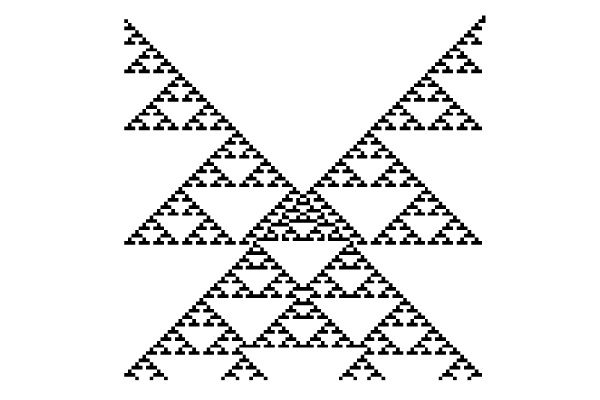

In [21]:
p

We conclude that even very simple ABMs can have very complex behaviour.

Let's try it with a random initial condition or a different rule...

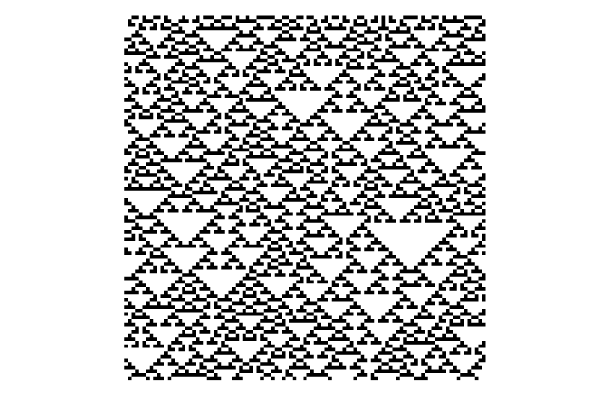

In [19]:
p, data = CA1D.run(;rules = rule22, gridsize = n, initial_condition="random", nsteps=steps, update="synchronous")
p

## A closer look at Agents.jl
The CA is too simple to illustrate all the features that are present in general ABMs. In particular, the lack of distinction between the space  grid and the agents is not generic. 

Agents.jl provides framework for constructing, running and analysing a broad class of ABMs. It *is* faster than writing yourself from scratch.


### Features of a general ABM

* an **agent** object with its own features
* a **model** object with its own features
* a **space** in which the agents live (in Agents.jl the space is a feature of the model, "no space" is possible)
* an **agent update** function
* a **model update** function
* a **scheduler**: a protocol for deciding the order in which the agents in the model run their update functions

### Overview of the structure of the Agents.jl framework
From https://juliadynamics.github.io/Agents.jl/dev/tutorial/ 

<img src="files/images/AgentsJL_overview.png" alt="Agents" style="width: 400px;"/>



### Data types in the Agents.jl framework

![Overview of Agents.jl](files/images/AgentsJL_model_object_structure.png "Agents.jl")

from https://juliadynamics.github.io/Agents.jl/dev/tutorial/ 

## Example 1: the 1D CA "under the hood"

Let's look at how the code for the 1D CA above fits into this framework.

There are lots of other examples in the Agents.jl documentation.

### Step 1 : defining the agent, space and model objects

Agents are always defined as mutable subtypes of ```AbstractAgent```. Depending on the space, the agent must have certain properties. For example, when the space is a ```GridSpace```, the agent must have a ```pos``` field of the appropriate dimension:

In [22]:
mutable struct CA1DAgent <: AbstractAgent
    id::Int # The identifier number of the agent
    pos::Dims{1} # The x location of the agent on a 1D grid
    state::Int # The state of the agent - 0 or 1
end

### Step 1 : defining the agent, space and model objects

Agents.jl pre-defines several types of agent matching with different types of space and provides a macro to customise these. In our case, we want to customise a ```GridAgent{1}```:

In [23]:
@agent CA1DAgent GridAgent{1} begin
    state::Int
end

### Step 1 : defining the agent, space and model objects

The space in this case is a 1D grid

In [24]:
gridsize = 101
space = GridSpace((gridsize,), metric=:euclidean, periodic = true)

GridSpace with size (101,), metric=euclidean and periodic=true

### Step 1 : defining the agent, space and model objects

The model incorporates the agent, the space and any additional properties needed to specify the model.

In our case, the only additional properties the model needs is the rules that we have defined above

In [29]:
space = GridSpace((gridsize,), metric=:euclidean, periodic = true)
properties = Dict(:rules => rule110)
model = ABM(CA1DAgent, space; properties)

AgentBasedModel with 0 agents of type CA1DAgent
 space: GridSpace with size (101,), metric=euclidean and periodic=true
 scheduler: fastest
 properties: Dict(:rules => Dict("000" => 0,"111" => 0,"001" => 1,"011" => 1,"101" => 1,"110" => 1,"010" => 1,"100" => 0))

### Step 1 : defining the agent, space and model objects

After creating the model, we now need to add the agents to it. In this case, there is an agent at each point on the grid. Let's start off with all of them set to state 0 except for the last one:


In [30]:
for idx in 1:gridsize
    add_agent_pos!(CA1DAgent(idx, (idx,), 0), model)
end
model.agents[gridsize].state = 1

1

### Aside: Using a function to initialise an ABM

It is a good idea to package all of this together into a single function to initialise an ABM. Here we take advantage of Julia's ability to define default function arguments:

In [26]:
function initialise(;rules = rule110, gridsize = 101)
    space = GridSpace((gridsize,), metric=:euclidean, periodic = true)
    properties = Dict(:rules => rules)
    model = ABM(CA1DAgent, space; properties)
    
    for idx in 1:gridsize
        add_agent_pos!(CA1DAgent(idx, (idx,), 0), model)
    end
    model.agents[gridsize].state = 1  
    return model
end

initialise (generic function with 1 method)

### Step 2 : defining the agent update function

This is where all of the action takes place:

In [31]:
function agent_step!(agent, model)
    neighbourhood = nearby_ids(agent.pos, model)
    str = ""
    for idx in neighbourhood
        str=str*string(model.agents[idx].state)
    end
    agent.state = model.rules[str]
end

agent_step! (generic function with 1 method)

### Step 3 : running the model and extracting data

In [32]:
nsteps = 50
adata = [:pos, :state]
data, _ = run!(model, agent_step!, nsteps; adata);

In [33]:
data[1:5,:]

,step,id,pos,state
,Int64,Int64,Tuple…,Int64
1,0,1,"(1,)",0
2,0,2,"(2,)",0
3,0,3,"(3,)",0
4,0,4,"(4,)",0
5,0,5,"(5,)",0


Agents.jl uses a DataFrame to return the data from run. You need to learn how to manipulate them

In [34]:
# Process the data into a simple array for plotting
    A = zeros(Int64, (nsteps+1, nagents(model)))
    for i in 0:nsteps
        snapshot = data[data[!,:step] .== i, :]
        for j in Iterators.flatten(snapshot.pos)
            A[i+1,j] = snapshot.state[j]
        end
    end

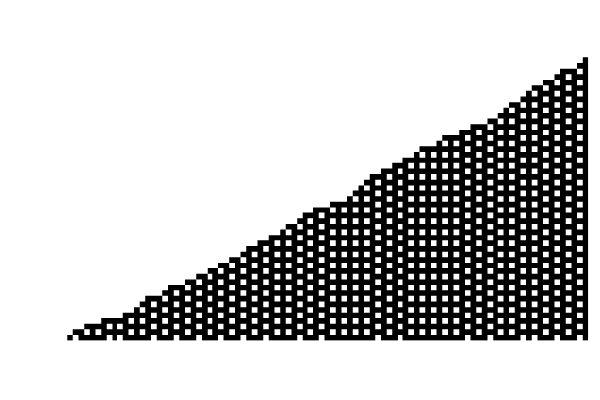

In [35]:
 # Reverse the image to make it plot nicer
    B = map( x -> x == 0 ? 1 : 0, A)
    p = plot(Gray.(B), aspect_ratio = :equal, ylim=(0,nsteps+1), axis=nothing, xaxis=false, yaxis=false)

### Synchronous vs asynchronous update - defining a model update function

What happened? We need our model to update synchronously. This is most easily done by defining a model update function that updates the agents:

In [36]:
function model_step!(model)
    new_states =  fill(0, nagents(model))
    for agent in allagents(model)
        neighbourhood = nearby_ids(agent.pos, model)
        str = ""
        for idx in neighbourhood
            str=str*string(model.agents[idx].state)
        end
        new_states[agent.id] = model.rules[str]
    end
    
    # Now that we have worked out all the new states, overwrite the old states
    for k in keys(model.agents)
        model.agents[k].state = new_states[k]
    end
end

model_step! (generic function with 1 method)

### Synchronous vs asynchronous update - defining a model update function

Now run again with a different form of the run!() function. Agents.jl provides a ```dummystep``` function for ABMs that don't require an ```agent_step!()``` function:

In [37]:
model = initialise(;rules = rule110, gridsize = 101)
nsteps = 50
adata = [:pos, :state]
data, _ = run!(model, dummystep, model_step!, nsteps; adata);

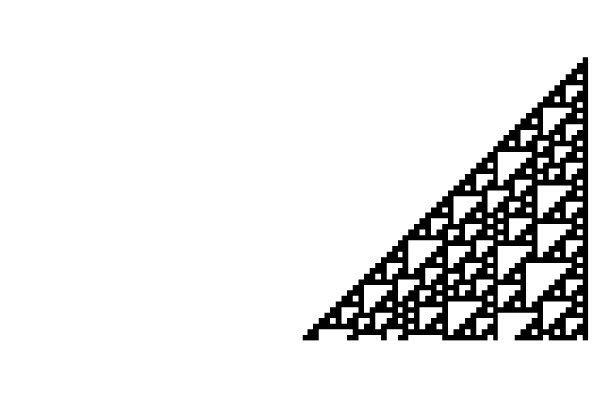

In [38]:
# Process the data into a simple array for plotting
    A = zeros(Int64, (nsteps+1, nagents(model)))
    for i in 0:nsteps
        snapshot = data[data[!,:step] .== i, :]
        for j in Iterators.flatten(snapshot.pos)
            A[i+1,j] = snapshot.state[j]
        end
    end

 # Reverse the image to make it plot nicer
    B = map( x -> x == 0 ? 1 : 0, A)
    p = plot(Gray.(B), aspect_ratio = :equal, ylim=(0,nsteps+1), axis=nothing, xaxis=false, yaxis=false)

### Aside: Running an ABM inside a function

As with initialisation, it can be helpful to wrap these commands into a single function that just returns the relevant data:


In [39]:
function run(;rules = rule110, gridsize = 100, nsteps=20)
    # Initialise a new ABM
    model = initialise(rules=rules, gridsize=gridsize)
    # Specify what data to record from the simulation
    adata = [:pos, :state]
    # Run the model
    data, _ = run!(model, dummystep, model_step!, nsteps; adata)
    # Process the data into a simple array for plotting
    A = zeros(Int64, (nsteps+1, nagents(model)))
    for i in 0:nsteps
        snapshot = data[data[!,:step] .== i, :]
        for j in Iterators.flatten(snapshot.pos)
            A[i+1,j] = snapshot.state[j]
        end
    end
    # Reverse the image to make it plot nicer
    B = map( x -> x == 0 ? 1 : 0, A)
    p = plot(Gray.(B), aspect_ratio = :equal, ylim=(0,nsteps+1), axis=nothing, xaxis=false, yaxis=false)
    return p, A
end

run (generic function with 1 method)

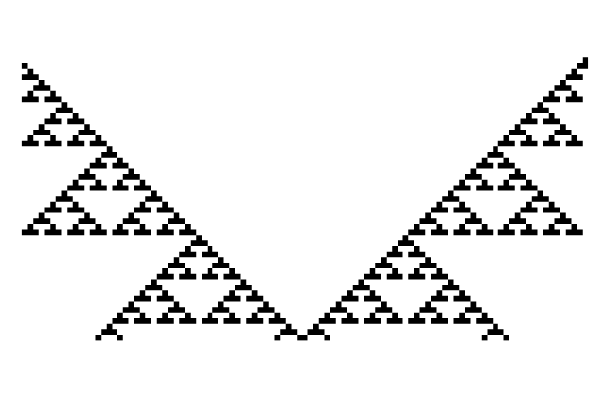

In [40]:
p, _ = run(rules = rule22, gridsize=101, nsteps = 50)
p

## Example 2: Traffic flow patterns

* Suppose we have $N = 100$ drivers who commute every day from point 1 to point 4 on a simple road network:
<img src="files/images/network1.png" alt="Drawing" style="width: 200px;"/>
* There are multiple paths in the network leading from 1 to 4.
* The travel time for each link, $i$, depends on the number of drivers, $x_i$, travelling on that link: generally travel time increases as the usage goes up.
* Build a model to estimate the average travel time from 1 to 4.

### Wardrop equilibrium and congestion games

We can think of this problem as a repeated multiplayer game in which each player (agent) tries to choose the route that minimises its travel time subject to the choices of all the other agents.

[John Wardrop](https://en.wikipedia.org/wiki/John_Glen_Wardrop) (a Warwick local!) suggested in 1952 that the observed pattern of use should satisfy the following principle: 

> journey times in all routes actually used are equal and less than those that would be experienced by a single vehicle on any unused route.

This is nowadays known as Wardrop equilibrium.

### Wardrop equilibrium and congestion games

It is a multiplayer analogue of a Nash equilibrium: no driver can improve their journey time by unilaterally switching to a different route.

Can we build an ABM to demonstrate the existence of Wardrop equilibrium from simple and plausible behavioural rules?

### ABM model of commuter patterns
We shall assume that the travel time, $\tau_i$, for each link, $i$, is a linear function of the number of agents $x_i$ travelling on that link on a given day:
$$ \tau_i(x_i) = a_i\ x_i + b_i $$
with the parameters $a_i$ and $b_i$ varying from link to link. These are called **demand-delay functions**.

### Model description:
* Each agent has a prefered route.
* At each step (1 day) each agent travels its prefered route.
* Travel times for all routes are calculated based on the choices of the agents.
* Each agent compares travel time, $\tau_\text{c}$, of its current prefered route to the travel time of a randomly chosen alternative route, $\tau_\text{a}$, and calculates $\Delta \tau = \tau_\text{a} - \tau_\text{c}$. 
* If $\Delta \tau <0$, the agent updates its prefered route with probability
$$P = 1 - \exp(\Delta \tau/T),$$
before the next iteration where $T$ is a model parameter.

### Implementation of the model

First we need to define the graph. To do this we use LightGraphs.jl:

In [41]:
using LightGraphs
using GraphPlot, Compose
using Statistics
using DataFrames

# Make a graph
G = DiGraph(4) # graph with 4 vertices
add_edge!(G, 1, 2)
add_edge!(G, 1, 3)
add_edge!(G, 2, 4)
add_edge!(G, 3, 4)

true

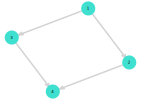

In [42]:
nodelabel = 1:nv(G)
gplot(G, nodelabel=nodelabel)

Next we make a list the available paths from 1 to 4

In [43]:
include("code/all_simple_paths.jl")
paths = all_simple_paths(G, 1, 4)

SimplePathIterator{Int64}({4, 4} directed simple Int64 graph, 1, Set([4]), nothing)

In [44]:
for (i, path) in enumerate(paths)
    println(i, " : ", path)
end

1 : [1, 3, 4]
2 : [1, 2, 4]


We use a dictionary to store the parameters $(a_i, b_i)$ for each link:

In [47]:
linkparams = [(0.1, 0.0), (0.0, 15.0), (0.0, 15.0), (0.1, 0.0)];

Since paths can share links, it will be helpful to define a link-path adjacency matrix:

$$A_{i j} = \left\{\begin{array}{ll}1& \text{if link $i$ is part of path $j$}\\
          0 & \text{otherwise}\end{array}\right.$$

In [45]:
function link_path_adjacency(link, path)
    for i in 1:(length(path)-1)
        (link.src == path[i] && link.dst == path[i+1]) && return 1
    end
    return 0
end

E = collect(edges(G))
A = zeros(Int64, (length(E), length(paths)))
for (i, edge) in enumerate(E), (j, path) in enumerate(paths)
    A[i,j] = link_path_adjacency(edge, path)
end
A

4×2 Array{Int64,2}:
 0  1
 1  0
 0  1
 1  0

Now we define demand-delay functions and store them as a dictionary (again) of functions that will be passed as properties to the model. This is a very dense piece of code so check it at home: 

In [48]:
n = length(linkparams)
a1 = collect(1:n)
a2 = [x -> linkparams[i][1] * x + linkparams[i][2] for i in 1:n]
demand_delay_functions = Dict( a1 .=> a2)

Dict{Int64,var"#14#16"{Int64}} with 4 entries:
  4 => #14
  2 => #14
  3 => #14
  1 => #14

Now we are ready to start setting up the ABM.

First we define the **agent** object. Our agents have three properties: 
* an id : every agent in Agents.jl must have a unique integer identifier
* current preferred route
* travel time for that route (not strictly necessary?)

In [33]:
mutable struct driverAgent <: AbstractAgent
    id::Int
    route_choice::Int
    travel_time::Float64
end

Note that our custom-defined **driverAgent** object inherits properties from **AbstractAgent** which is defined by Agents.jl. This means we only need to worry about the aspects of the agent that are specific to our particular model.

Next we have to decide what information needs to be passed to the **model** object as properties:
* the "temperature" parameter, $T$
* the link-path adjacency matrix we contructed above
* the demand-delay functions we defined above
* an array to store the travel times for each path

In [34]:
route_times = zeros(Float64,length(paths))
properties = Dict{Symbol, Any}(
    :T => 50.0, 
    :link_path_matrix => A, 
    :demand_delay => demand_delay_functions, 
    :route_times => route_times,
    :routes => paths
)

Dict{Symbol,Any} with 5 entries:
  :T                => 50.0
  :routes           => SimplePathIterator{Int64}({4, 4} directed simple Int64 g…
  :demand_delay     => Dict{Int64,var"#14#16"{Int64}}(4=>#14,2=>#14,3=>#14,1=>#…
  :route_times      => [0.0, 0.0]
  :link_path_matrix => [0 1; 1 0; 0 1; 1 0]

Note that we again use a dictionary to pass properties to the model. The :x syntax creates a symbol in Julia - here it helps avoid confusion with variables that might contain values.

### Building the model

It is common practice to encapsulate the building and initialisation into a function so that model instances can be created easily

In [35]:
function initialise(;numagents = 100, properties = Dict{Symbol,Any})
    model = ABM(driverAgent, scheduler=fastest, properties=properties)
    for i in 1:numagents
        add_agent!(model, 1, 0.0)
    end
    return model
end

initialise (generic function with 1 method)

### Defining the agent update function

In [36]:
function agent_step!(agent, model)
    T = model.properties[:T] 
    previous_route_times = model.properties[:route_times]; 
    nroutes = length(previous_route_times)
    # Check how long agent's current route choice took the previous day
    t = previous_route_times[agent.route_choice]
    # Make a list of alternative routes
    alternative_routes = collect(1:nroutes)
    deleteat!(alternative_routes, alternative_routes .== agent.route_choice)
    # Check how long a random alternative would have taken
    alternative_route = rand(alternative_routes)
    t_alternative = previous_route_times[alternative_route]
    # Calculate the difference between the times for chosen route and alternative
    Δt = t_alternative - t
    # Switch route if Δt is negative with a probability that goes to 0 with Δt
    if Δt <=0
        P = 1.0 - exp(Δt/T)
        rand() < P && (agent.route_choice = alternative_route)
    end
end

agent_step! (generic function with 1 method)

### Defining the model update function
At each iteration of the model, this is run *after* all the agents have updated.
The model update needs to do the following:
1. count how many agents chose each route in the previous iteration. These are the "path flows", $\{h_i,\ i=1\ldots n_p\}$, where $n_p$ is the number of paths from origin to destination.
2. use the path flows to determine how many agents use each link (remember in general paths can share links). The "link flows",  $\{x_i,\ i=1\ldots n_e\}$, where $n_e$ is the number of edges in the network. The link-path adjacency matrix comes in handy here:

### Defining the model update function

$$ x_i = \sum_{j=1}^{n_p} A_{i\,j}\, h_j $$
3. Calculate the path travel times and update the agents' estimates of the travel times for their prefered routes. The link-path adjacency matrix again comes in handy here. The travel time for path $k$ is:
$$ T_k = \sum_{j=1}^{n_e} A_{j\,k}\, \tau_j(x_j) $$

Here's the function:

In [37]:
function model_step!(model)
    A = model.properties[:link_path_matrix]
    nlinks=size(A)[1]
    npaths=size(A)[2]
    # Count how many agents chose each route
    path_counts = zeros(Int64,npaths)
    for agent in allagents(model)
        r = agent.route_choice
        path_counts[r]+=1
    end
    # Derive the link counts from the path counts
    link_counts = A * path_counts
    # Derive the link travel times from the link counts
    link_travel_times = [model.properties[:demand_delay][i](link_counts[i]) for i in 1:nlinks]
    # Calculate updated path travel times for each route based on the link travel times
    model.properties[:route_times] = link_travel_times'*A
    # Update the agents travel times
    for agent in allagents(model)
        r = agent.route_choice
        agent.travel_time = model.properties[:route_times][r]
    end
end

model_step! (generic function with 1 method)

## Running the model and gathering the data

In [38]:
# Set up data gathering
adata = [:route_choice, :travel_time]
n = 100  # number of time steps to run the simulation
when = 1:n  # At which steps to collect data
# Initialise the model
model = initialise(properties = properties)
# Run the model
data, _  = run!(model, agent_step!, model_step!, n; adata);

* `adata` are the agent properties to measure during the run.
* `when` specifies the time steps you want to gather data. You don't have to output at every step.
* `properties` is the dictionary of model properties defined above.
* `agent_step!` and `model_step!` are the functions defined above.

## Analysing the output

The output looks like this:

In [39]:
data[1:10, :]

,step,id,route_choice,travel_time
,Int64,Int64,Int64,Float64
1,0,1,1,0.0
2,0,2,1,0.0
3,0,3,1,0.0
4,0,4,1,0.0
5,0,5,1,0.0
6,0,6,1,0.0
7,0,7,1,0.0
8,0,8,1,0.0
9,0,9,1,0.0


## Analysing the output

You will need to learn a bit about manipulating data frames: https://juliadata.github.io/DataFrames.jl/stable/

In [40]:
using DataFrames
gdf = groupby(data, :step)
df_average_travel = combine(gdf, :travel_time => mean => :T)
delete!(df_average_travel, 1)

,step,T
,Int64,Float64
1,1,25.0
2,2,22.178
3,3,21.568
4,4,20.578
5,5,20.392
6,6,20.162
7,7,20.128
8,8,20.018
9,9,20.008


Especially the [split-apply-combine](https://juliadata.github.io/DataFrames.jl/stable/man/split_apply_combine/) functionality of the `groupby` command which allows us to group the data by the step and the ```combine``` command to perform operations such as counts or averages on the groups. This is the analogue of the `pandas.DataFrame.groupby()` for those of you familiar with Python's pandas library.

## Path flows

Let's plot the number of users of each path

In [41]:
gdf = groupby(data, [:step, :route_choice])
df = combine(gdf, nrow => :count)
routes_df = groupby(df, :route_choice);

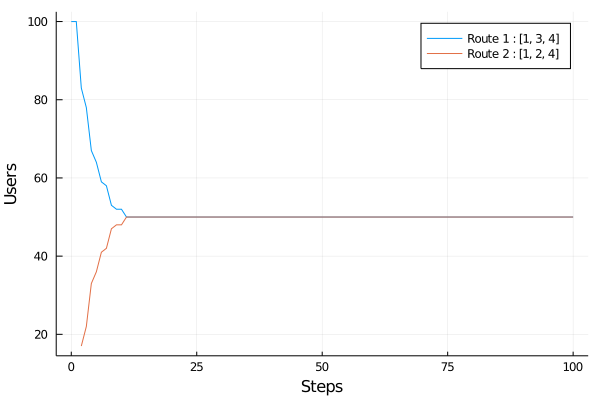

In [45]:
p1 = plot()
paths = collect(model.properties[:routes])
for (key, df) in pairs(routes_df)
    idx = key.route_choice
    label = "Route "*string(idx)*" : "*string(paths[idx])
    plot!(df.step, df.count, label=label )
end
xlabel!("Steps")
ylabel!("Users")

Perhaps unsurprisingly, the agents quickly learn to distribute themeselves evenly between the two available routes.

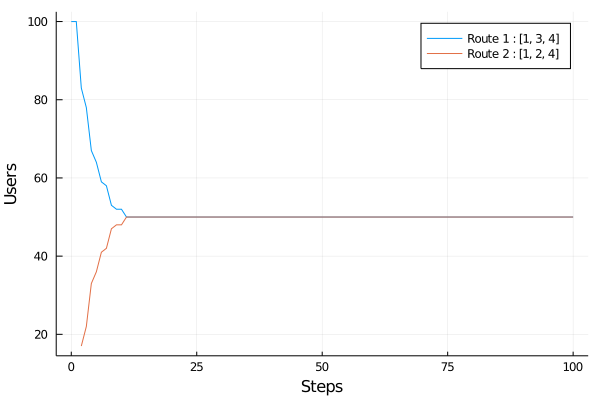

In [46]:
p1

## Average travel time

Let's plot the average travel time

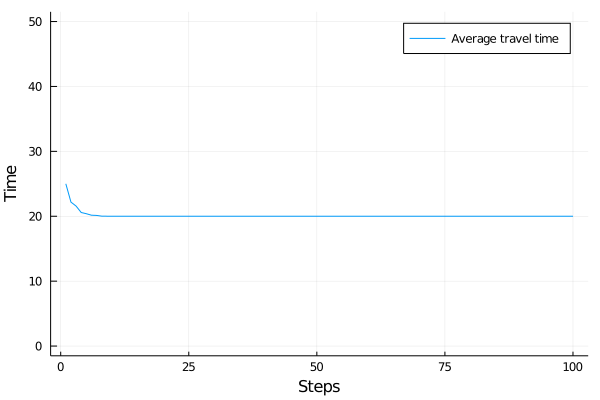

In [47]:
p2 = plot(df_average_travel.step, df_average_travel.T, ylims=[0.0, 50.0], label="Average travel time")
xlabel!("Steps")
ylabel!("Time")

## Average travel time
The system quickly settles to a Wardrop equilibrium of 20 minutes - consistent with the demand delay functions for the two routes.

In [ ]:
p2

## Aggregating data on the fly and querying the model

It is possible to use the ```adata``` keyword to apply functions (such as `mean()` or `median()`) to the set of all agents' data at each step to avoid returning excessive amounts of data from large simulations and then doing complicated analyses of dataframes. 

You can also query the model object itself by defining functions that apply to the model and pass them into the ```run!()``` function with the ```mdata``` keyword. 

Here is an example:

In [50]:
# Specify a function to apply to agents' field to aggregate data on the fly
adata = [(:travel_time, mean)]

# Define functions that take the model as argument and return some of the model properties
t1(model) = model.properties[:route_times][1]
t2(model) = model.properties[:route_times][2]

mdata = [t1, t2]

# Initialise and run the model to gather data as before
n = 100  
when = 1:n  
model = initialise(properties = properties)
data_from_agents, data_from_model = run!(model, agent_step!, model_step!, n; adata, mdata);

## Aggregating data on the fly and querying the model

In [51]:
data_from_agents[1:5, :]

,step,mean_travel_time
,Int64,Float64
1,0,0.0
2,1,25.0
3,2,22.048
4,3,20.648
5,4,20.338


In [52]:
data_from_model[1:5, :]

,step,t1,t2
,Int64,Float64,Float64
1,0,20.0,20.0
2,1,25.0,15.0
3,2,23.2,16.8
4,3,21.8,18.2
5,4,21.3,18.7


## A (slightly) more complicated example

Let's add an additional road linking 2->3 with a cost of 5.0 -  a new bridge perhaps.

There is now an additional path in the network. Importantly some links are now shared between paths.

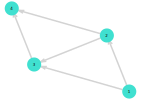

In [53]:
G2 = DiGraph(4) # graph with 4 vertices
add_edge!(G2, 1, 2)
add_edge!(G2, 1, 3)
add_edge!(G2, 2, 4)
add_edge!(G2, 3, 4)
add_edge!(G2, 2, 3)
paths = [[1,2,4], [1,3,4], [1,2,3,4]]
linkparams2 = [(0.1, 0.0), (0.0, 15.0), (0.0, 5.0), (0.0, 15.0), (0.1, 0.0)];
nodelabel = 1:nv(G2)
gplot(G2, nodelabel=nodelabel)

## Run the model again

I have condensed all the above code into a module ```code/CG.jl```:

In [54]:
include("code/CG.jl")

Main.CG

In [55]:
data2, p3, p4 = CG.run(G=G2, link_parameters = linkparams2);

## Path flows including the bridge

Let's plot the number of users of each path

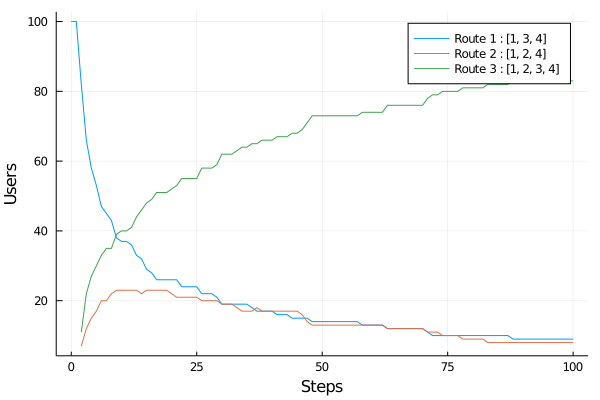

In [56]:
p4

The agents are now all switching to route 3 (including the bridge). It must be faster right?

## Average travel time

Wrong! When all agents switch to route 2, the average travel time now tends to 25 minutes.

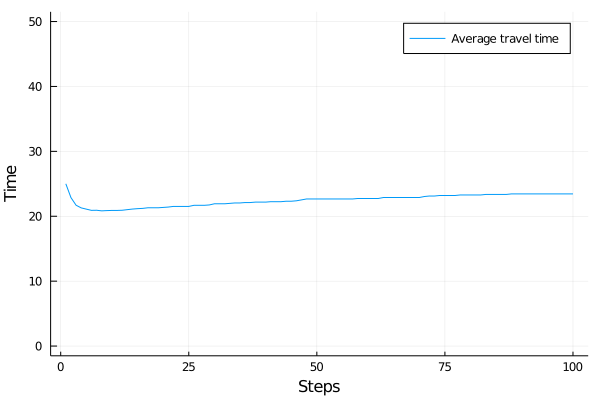

In [57]:
p3

The fact that adding *extra capacity* to transport networks can sometimes result in *increased* journey times is known as Braess' paradox.

## Mathematical analysis of the congestion game: decision variables and constraints
Let us now formulate the congestion game as an optimisation problem.

Decision variables: link and path flows:
$$X = (x_1, \ldots, x_{n_v}, h_1, \ldots h_{n_p})$$
These variables are not all independent. The following **constraints** must be satisfied:
* Flows are non-negative:
$$x_i\geq 0\ \ \ i=1\ldots n_v$$
$$h_j\geq 0\ \ \ j=1\ldots n_p$$

## Mathematical analysis of the congestion game: decision variables and constraints

* Path flows must match demand:
$$\sum_{i=1}^{n_p} h_i = 100$$
* Link flows must be consistent with path flows:
$$ \sum_{j=1}^{n_p} A_{i\,j}\,h_j = x_i  \ \ \ i=1\ldots n_v$$

## Mathematical analysis of the congestion game: optimand

What to optimise? Total travel time?

$$ F_{SO}(X) = \sum_{i=1}^{n_v} x_i\, \tau_i(x_i) $$.

We already know from our ABM that minimising the total travel time does not yield a Wardrop equilibrium. Minimising the total travel time yields a flow pattern which is called the "social optimum".

## Mathematical analysis of the congestion game: optimand

A flow pattern corresponding to a Wardrop equilibrium is obtained by minimising the Beckmann potential:

$$ F_{WE}(X) = \sum_{i=1}^{n_v} \int\, \tau_i(x_i)\ dx_i.$$

This is not obvious. The difference between the social optimum and the Wardrop equilibrium is called the "price of anarchy". 

## A closer look at the Beckmann potential

Why does the minimising the Beckmann potential produce a Wardrop equilibrium? Consider the discrete case:

$$ F_{WE}(X) = \sum_{i=1}^{n_v} \sum_{n=1}^{x_i} \tau_i(n)$$

Suppose the $x_i$ are such that $F_{WE}$ is a minimum (there is at least one such choice) that is *not* a Wardrop equilibrium.

Then there is at least one driver (on route A with edges $e_1, e_2,\ldots e_n$ say)  who can improve travel time by switching route (to route B with edges $e_1^\prime, e_2^\prime \ldots e_m^\prime$ say). 

## A closer look at the Beckmann potential

Upon switching, $F_{WE}$ decreases by $\sum_{j=1}^n \tau_{e_j}(x_{e_j})$ which is the travel time for route A and then increases by the new travel time for route B.

Since the the travel time of B is less than that of A, $F_{WE}$ decreases.

This contradicts the initial assumption of a minimum.

## Homework (or exam!) question
Consider the network above with demand-delay functions:
1. [1,2] : $\tau_1(x) = x/10 $ 
2. [1,3] : $\tau_2(x) = 15 $ 
3. [2,3] : $\tau_3(x) = 5 $ 
4. [2,4] : $\tau_4(x) = 15 $ 
5. [3,4] : $\tau_5(x) = x/10 $ 

Label the paths p1 = [1,2,4], p2 = [1,3,4], p3 = [1,2,3,4]
* Show that minimising $F_{SO}(X)$ gives $h_1=50$, $h_2 = 50$ and $h_3 = 0$ and a travel time of 20.0.
* Show that miminimising $F_{WE}(X)$ gives $h_1=0$, $h_2 = 0$ and $h_3 = 100$ and a travel time of 25.0.

This example is solvable by hand but larger networks quickly become intractable and we need to resort to numerical optimisation.

### Solution:

There are 8 decision variables: $\{x_1, x_2, x_3, x_4, x_5, h_1, h_2, h_3\}$.
The objective function to find a social optimum is:
$$F_\text{SO}(x_1, x_2, x_3, x_4, x_5) = \sum_{i=1}^5 x_i\,\tau_i(x_i) $$
With the link labels and parameters given above, the optimand is
$$F_\text{SO}(x_1, x_2, x_3, x_4, x_5) = \frac{x_1^2}{10} + 15 x_2 + 5 x_3 + 15 x_4 + \frac{x_5^2}{10},$$
and the constraints are
\begin{align}
100 & = h_1 + h_2 + h_3\\
x_1 & = h_1 + h_3 \\
x_2 & = h_2\\
x_3 & = h_3\\
x_4 & = h_1\\
x_5 & = h_2 + h_3.
\end{align}
Check that you understand where these come from.

### Solution:

We can eliminate the path flows in terms of the link flows: $h_1= x_4$, $h_2 = x_2$ and $h_3 = x_3$.
There remain 3 equation relating the 5 path flows:

\begin{align}
100 &= x_2 + x_3 + x_4 \\
x_1 &= x_4 + x_3\\
x_5 &= x_2 + x3.
\end{align}

Using these equations we can reduce the 5 degrees of freedom in the optimand to 2. We eliminate $x_2$, $x_4$ and $x_5$ and write everything in terms of $x_1$ and $x_3$:

\begin{align}
x_2 &= 100 - x_1\\
x_4 &= x_1 - x_3\\
x_5 &= 100 - x_1 + x_3.
\end{align}

The optimand is now a function of two variables:

$$F_\text{SO}(x_1, x_3) = \frac{x_1^2}{10} + 15\, (100-x_1) + 5\, x_3 + 15\, (x_1-x_3) + \frac{(100-x_1+x_3)^2}{10}.$$

### Solution:

We minimise by setting $\nabla\,F_\text{SO}(x_1, x_3) = 0$ but we should bear in mind that we still have the positivity constraints $x_1 \geq 0$, $x_3 \geq 0$. 

This gives:
\begin{align}
\frac{\partial F_\text{SO}}{\partial x_1} &= \frac{2}{5}\, x_1  - \frac{1}{5}\, x_3 - 20 &= 0 \\
\frac{\partial F_\text{SO}}{\partial x_3} &= -\frac{1}{5}\, x_1 + \frac{1}{5}\, x_3 + 10 &= 0.
\end{align}

Solving these gives:
\begin{align}
x_1 &= 50\\
x_3 &= 0.
\end{align}

Note how, in this case, the optimum turns out to be on the boundary of the feasible set.

The remaining link flows are then: $x_2 = 50$, $x_4 = 50$, $x_5 = 50$. The path flows are $h_1 = 50$, $h_2 = 50$ and $h_3 = 0$.

A similar calculation with a different optimand allows one to obtain the Wardrop equilibrium.

## Constrained optimisation

Computation of Wardrop equilbria and social optima in congestion games require optimisation of a nonlinear function of the link and path flows subject to a set of linear constraints. We must solve problems of the form:

$$ \min_{X} F(X)$$

subject to 

$$ A\,X = b$$
$$ X \geq 0$$



## Constrained optimisation
In MA934 we learned that solutions of constrained linear optimisation problems are always on the boundary of the feasible set. This is not true for constrained nonlinear optimisation problems.
![Constrained optimisation](files/images/Inequality_constraint_diagram.svg.png "Network 2")

[Onmyphd](https://commons.wikimedia.org/wiki/User:Onmyphd) [Inequality constraint diagram](https://commons.wikimedia.org/wiki/File:Inequality_constraint_diagram.svg) [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/legalcode)

## Frank - Wolfe algorithm

The Frank-Wolfe algorithm is an iterative algorithm for solving nonlinear optimisation problems with constraints.The basic idea is to linearise:
$$ F(X_k+X) = F(X_k) + (X-X_k) \cdot \nabla\, F(X_k) + \ldots$$
At each step of the iteration we linearise the objective function about the current point and the obtain the next point by solving the resulting contstrained linear optimisation problem - e.g. using the Dantzig algorithm.
* initial guess: $k=0$, $X = X_0$
* Solve the linearised problem
$$s_k = \text{arg} \min_{s} s\cdot \nabla\,F(s)$$
subject to 
$$ A\,s = b$$
$$ s \geq 0$$
* Calculate step size: $\gamma_k = \frac{2}{k+2}$ 
* Update our solution: $X_{k+1} = X_k + \gamma_k\,(s_k - X_k)$, $\ \ \ k=k+1$


## Useful links
* Agents.jl documentation : https://github.com/JuliaDynamics/Agents.jl/blob/master/docs/src/index.md 

## References